# TP3 INFO8003
The idea behind this notebook is to get familiar with RL algorithms related to continuous domain. In this notebook we focus on the fitted-Q algorithm and the Q-learning algorithm.

We describe the domain below:

- **State space**: $S = \{(p,v) \in \mathbb{R}^2 | |p| \leq 1, |v| \leq 3 \}$ and a *terminal state*. A terminal state can be seen as a regular state in which the system is stuck and for which all the future rewards obtained in the aftermath are zero.
    - A terminal state is reached if $|p_{t+1}| > 1$ or $|v_{t+1}| > 3$. 

- **Action space**: $ A = \{4,-4\}$.
- **Dynamics**: $\dot{p} = v$, $\dot{v} =  \frac{a}{m (1+Hill^\prime(p)^2)} - \frac{g Hill^\prime(p)}{1+Hill^\prime(p)^2} - \frac{s^2 Hill^{\prime}(p) Hill^{\prime \prime}(p) }{1+Hill^\prime(p)^2}$,  
    where $m = 1$, $g = 9.81$ and

  $$
  Hill(p) = 
  \begin{cases}  
    p^2 + p & \text{if} \quad p < 0 \\
    \frac{p}{\sqrt{1+5p^2}} & \text{otherwise}.
  \end{cases}
  $$

    - The discrete-time dynamics is obtained by discretizing the time with the time between $t$ and $t+1$ chosen equal to $0.1s$.
- **Integration time step**: $0.001$.   
- **Reward signal**: 
  $$
  r(p_t,v_t,a_t) = 
  \begin{cases} 
    -1 & \text{if} \quad p_{t+1} < -1 \quad \text{or} \quad |v_{t+1}| > 3 \\
    1 & \text{if} \quad p_{t+1} > 1 \quad \text{and} \quad |v_{t+1}| \le 3 \\
    0 & \text{otherwise}.
  \end{cases}
  $$

- **Discount factor**: $\gamma = 0.95$.
- **Time horizon**: $T \rightarrow +\infty$.
- **Initial state**: $p_0 \sim \mathcal{U}(\left[-0.1, 0.1 \right])$, $v_0 = 0$.

This domain is a *car on the hill* problem, and will be referred to by this name from now on. The figure here below shows an illustration of the domain.

<p align="center"> 
    <img src="caronthehill_display.jpeg" alt="Display of the position $p=0$ and the speed $s=1$ of the car.">
    </p>


The implementation of this domain has already been implemented for you to answer the following questions

In [2]:
import gymnasium as gym
import pygame
import imageio
import numpy as np
from gymnasium import spaces
from typing import Optional, Tuple, Union
from display_caronthehill import save_caronthehill_image


class CarOnHillEnv(gym.Env):
    """
    Car on Hill environment following the Gymnasium interface.

    State space: position [-1, 1], velocity [-3, 3]
    Action space: {-4, 4}
    """


    def __init__(self, render_mode: Optional[str] = None):
        super().__init__()

        self.action_space = spaces.Discrete(2)  # 0: -4, 1: 4
        self.observation_space = spaces.Box(
            low=np.array([-1.0, -3.0]),
            high=np.array([1.0, 3.0]),
            dtype=np.float64
        )

        # Physics parameters
        self.dt = 0.001
        self.m = 1.0
        self.g = 9.81

        # Initial state bounds
        self.initial_position_range = (-0.1, 0.1)
        self.initial_velocity = 0.0

        # Discount factor
        self.gamma = 0.95

        # Initialize state
        self.state = None
        self.steps = 0

        self.render_mode = render_mode
        self.frames = []



    def _hill_function(self, p: float) -> float:
        if p < 0:
            return p**2 + p
        return p / np.sqrt(1 + 5 * p**2)

    def _hill_derivative(self, p: float) -> float:
        if p < 0:
            return 2 * p + 1
        return 1 / (1 + 5 * p**2)**(3/2)

    def _hill_second_derivative(self, p: float) -> float:
        if p < 0:
            return 2
        return -15 * p / (1 + 5 * p**2)**(5/2)

    def _dynamics(self, p: float, v: float, a: float) -> Tuple[float, float]:
        """Simulate dynamics for one time step (0.1s) using Euler integration."""
        steps = int(0.1 / self.dt)

        for _ in range(steps):
            hill_deriv = self._hill_derivative(p)
            hill_second = self._hill_second_derivative(p)

            v_dot = (a / (self.m * (1 + hill_deriv**2)) -
                    (self.g * hill_deriv) / (1 + hill_deriv**2) -
                    (v**2 * hill_deriv * hill_second) / (1 + hill_deriv**2))

            p += v * self.dt
            v += v_dot * self.dt

        return p, v

    def _get_reward(self, next_p: float, next_v: float) -> float:
        if next_p < -1 or abs(next_v) > 3:
            return -1
        elif next_p > 1 and abs(next_v) <= 3:
            return 1
        return 0

    def _is_terminal(self, p: float, v: float) -> bool:
        return abs(p) > 1 or abs(v) > 3

    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None) -> Tuple[np.ndarray, dict]:
        super().reset(seed=seed)
        self.frames = []
        p = self.np_random.uniform(*self.initial_position_range)
        v = self.initial_velocity

        self.state = np.array([p, v], dtype=np.float32)
        self.steps = 0

        return self.state, {}

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, dict]:
        assert self.state is not None, "Call reset before using step method."

        force = 4 if action == 1 else -4
        p, v = self.state
        next_p, next_v = self._dynamics(p, v, force)
        next_state = np.array([next_p, next_v], dtype=np.float32)

        reward = self._get_reward(next_p, next_v)
        terminated = self._is_terminal(next_p, next_v)
        truncated = False  # Infinite time horizon

        self.state = next_state
        self.steps += 1
        if self.render_mode == "gif":
            self.render(next_p, next_v)
        return next_state, reward, terminated, truncated, {}

    def render(self, position: float, velocity: float):
        """Render the current state of the environment."""
        if self.render_mode == "gif":
            frame = save_caronthehill_image(position, max(min(velocity, 3), -3))
            self.frames.append(frame)


    def save_gif(self, filename="car_on_hill.gif"):
        """Save the collected frames as a GIF."""
        if self.render_mode == "gif" and self.frames:
            imageio.mimsave(filename, self.frames, fps=10)
            print(f"GIF saved as {filename}")

<frozen importlib._bootstrap>:488: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


You can render a trajectory using the following code

In [3]:
env = CarOnHillEnv(render_mode="gif")


num_steps = 100
state, _ = env.reset()
for _ in range(num_steps):
    action = env.action_space.sample() # We implement a random policy here
    next_state, reward, terminated, truncated, _ = env.step(action)
    if terminated or truncated:
        break
    state = next_state

env.save_gif("car_on_hill.gif")

GIF saved as car_on_hill.gif


## Part 1: Fitted Q iteration

### Question 1: Fitted Q Iteration Algorithm

Implement the Fitted-Q-Iteration algorithm for the car on the hill environment. It should use a sklearn model for the regression algorithm. Propose two stopping rules for the computation of the $\widehat{Q}_N$-functions sequence and motivate them.

### Algorithm

#### Inputs:
- A set of four-tuples $\mathcal{F}$ (experience replay buffer)
- A regression algorithm

#### Initialization:
- Set $N$ to 0.
- Let $\hat{Q}_N$ be a function equal to zero everywhere on $\mathcal{S} \times \mathcal{A}$.

#### Iterations:
Repeat until stopping conditions are reached

1. **Increment Iteration Counter:**
   - $N \leftarrow N + 1$.

2. **Build the Training Set:**
   - Construct the training set $\mathcal{TS} = \{(i^l, o^l)\}, l = 1, \ldots, \#\mathcal{F}$ based on the function $\hat{Q}_{N-1}$ and on the full set of four-tuples $\mathcal{F}$:
     \[
     \begin{aligned}
     i^l &= (s^l, a^l), \\
     o^l &= r^l + \gamma \max_{a' \in \mathcal{A}} \hat{Q}_{N-1}(s^l_{+1}, a')
     \end{aligned}
     \]

3. **Induce the Function:**
   - Use the regression algorithm to induce from $\mathcal{TS}$ the function $\hat{Q}_N(s, a)$.



In [ ]:
# # You can use the implementation here below as a starting point
# import numpy as np
# from typing import List, Tuple
# from tqdm import tqdm

# class FittedQIteration:
#     def __init__(self, model, gamma: float, action_space: List[int]):
#         """
#         Initialize the Fitted Q-Iteration algorithm.

#         Parameters:
#         - model: A regression model from scikit-learn used to approximate the Q-function.
#         - gamma: The discount factor for future rewards.
#         - action_space: A list of possible actions in the environment.
#         """
#         self.model = model
#         self.gamma = gamma
#         self.action_space = action_space
#         self.q_function = None

#     def train(self, experience_replay: List[Tuple[np.ndarray, int, float, np.ndarray]], stopping_criteria: str):
#         """
#         Train the Q-function using the Fitted Q-Iteration algorithm.

#         Parameters:
#         - experience_replay: A list of experience tuples (state, action, reward, next_state).
#         - stopping_criteria: The criteria to stop training.
#         """
#         # Initialize Q function to zero
#         if self.q_function is None:
#             self.q_function = lambda s, a: 0

#         inputs = []
#         targets = []


#     def predict_Q(self, state: np.ndarray) -> np.ndarray:
#         """
#         Predict the Q-values for all actions given a state.

#         Parameters:
#         - state: The current state for which to predict Q-values.

#         Returns:
#         - An array of Q-values for each action in the action space.
#         """
#         return np.array([self.q_function(state, a) for a in self.action_space])

#     def predict_action(self, state: np.ndarray) -> int:
#         """
#         Predict the best action for a given state based on the Q-function.

#         Parameters:
#         - state: The current state for which to predict the best action.

#         Returns:
#         - The action with the highest Q-value.
#         """
#         return np.argmax(np.array([self.q_function(state, a) for a in self.action_space]))

In [4]:
import numpy as np
from typing import List, Tuple
from tqdm import tqdm
import matplotlib.pyplot as plt

class FittedQIteration:
    def __init__(self, model, gamma: float, action_space: List[int]):
        """
        Initialize the Fitted Q-Iteration algorithm.

        Parameters:
        - model: A regression model from scikit-learn used to approximate the Q-function.
        - gamma: The discount factor for future rewards.
        - action_space: A list of possible actions in the environment.
        """
        self.model = model
        self.gamma = gamma
        self.action_space = action_space
        self.q_function = None
        self.iteration_history = []

    def train(self, experience_replay: List[Tuple[np.ndarray, int, float, np.ndarray]],
              stopping_criteria: str, max_iterations: int = 100,
              convergence_threshold: float = 0.01):
        """
        Train the Q-function using the Fitted Q-Iteration algorithm.

        Parameters:
        - experience_replay: A list of experience tuples (state, action, reward, next_state).
        - stopping_criteria: The criteria to stop training ('iterations', 'convergence').
        - max_iterations: Maximum number of iterations for the 'iterations' stopping criteria.
        - convergence_threshold: Threshold for the 'convergence' stopping criteria.
        """
        # Initialize Q function to zero
        N = 0
        prev_q_values = np.zeros(len(experience_replay))

        pbar = tqdm(total=max_iterations)

        while True:
            N += 1
            pbar.update(1)

            # Build training set
            inputs = []
            targets = []

            for s, a, r, s_next in experience_replay:
                # Prepare input (state-action pair)
                inputs.append(np.concatenate([s, [self.action_space.index(a)]]))

                # Calculate target using the Bellman equation
                if s_next is None or self._is_terminal(s_next):  # Terminal state
                    target = r
                else:
                    # Get max Q-value for next state across all actions
                    next_q_values = np.array([self._predict_single(s_next, action)
                                             for action in self.action_space])
                    target = r + self.gamma * np.max(next_q_values)

                targets.append(target)

            # Convert to numpy arrays
            X = np.array(inputs)
            y = np.array(targets)

            # Fit regression model
            self.model.fit(X, y)

            # Save the model as the Q-function
            self.q_function = self.model

            # Check stopping criteria
            if stopping_criteria == 'iterations' and N >= max_iterations:
                break

            if stopping_criteria == 'convergence':
                # Calculate current Q-values for the same state-action pairs
                current_q_values = np.array([self._predict_single(s, a)
                                           for s, a, _, _ in experience_replay])

                # Calculate change in Q-values
                q_change = np.mean(np.abs(current_q_values - prev_q_values))
                self.iteration_history.append(q_change)

                # Store current Q-values for next iteration comparison
                prev_q_values = current_q_values.copy()

                # Check if converged
                if q_change < convergence_threshold:
                    break

        pbar.close()
        print(f"Training completed after {N} iterations")
        return self.iteration_history

    def _is_terminal(self, state):
        """Check if a state is terminal."""
        p, v = state
        return abs(p) > 1 or abs(v) > 3

    def _predict_single(self, state, action):
        """Predict Q-value for a single state-action pair."""
        if self.q_function is None:
            return 0

        # Prepare input for prediction
        X = np.concatenate([state, [self.action_space.index(action)]])
        X = X.reshape(1, -1)

        return self.q_function.predict(X)[0]

    def predict_Q(self, state: np.ndarray) -> np.ndarray:
        """
        Predict the Q-values for all actions given a state.

        Parameters:
        - state: The current state for which to predict Q-values.

        Returns:
        - An array of Q-values for each action in the action space.
        """
        if self.q_function is None:
            return np.zeros(len(self.action_space))

        return np.array([self._predict_single(state, a) for a in self.action_space])

    def predict_action(self, state: np.ndarray) -> int:
        """
        Predict the best action for a given state based on the Q-function.

        Parameters:
        - state: The current state for which to predict the best action.

        Returns:
        - The action with the highest Q-value.
        """
        q_values = self.predict_Q(state)
        return self.action_space[np.argmax(q_values)]

    def plot_convergence(self):
        """Plot the convergence history of Q-values."""
        if len(self.iteration_history) > 0:
            plt.figure(figsize=(10, 6))
            plt.plot(self.iteration_history)
            plt.title('Convergence of Q-values')
            plt.xlabel('Iteration')
            plt.ylabel('Mean absolute change in Q-values')
            plt.grid(True)
            plt.show()

### Question 2: Generating Sets of One-Step System Transitions

Propose two strategies for generating sets of one-step system transitions and motivate them.

In [5]:
def generate_uniform_random_samples(env, n_samples=10000):
    """
    Generate one-step system transitions using uniform random sampling.

    Parameters:
    - env: The environment
    - n_samples: Number of samples to generate

    Returns:
    - A list of transitions (state, action, reward, next_state)
    """
    samples = []

    for _ in range(n_samples):
        # Generate random state within bounds
        p = np.random.uniform(-1, 1)
        v = np.random.uniform(-3, 3)
        state = np.array([p, v])

        # Choose random action
        action = np.random.choice([0, 1])  # 0: -4, 1: 4
        force = 4 if action == 1 else -4

        # Compute next state and reward
        next_p, next_v = env._dynamics(p, v, force)
        next_state = np.array([next_p, next_v])

        reward = env._get_reward(next_p, next_v)

        # Check if terminal
        if env._is_terminal(next_p, next_v):
            next_state = None

        samples.append((state, force, reward, next_state))

    return samples

def generate_episode_based_samples(env, n_episodes=100, max_steps=100):
    """
    Generate one-step system transitions by simulating episodes.

    Parameters:
    - env: The environment
    - n_episodes: Number of episodes to simulate
    - max_steps: Maximum steps per episode

    Returns:
    - A list of transitions (state, action, reward, next_state)
    """
    samples = []

    for _ in range(n_episodes):
        state, _ = env.reset()

        for _ in range(max_steps):
            # Choose random action
            action = np.random.choice([0, 1])  # 0: -4, 1: 4
            force = 4 if action == 1 else -4

            # Take a step in the environment
            next_state, reward, terminated, truncated, _ = env.step(action)

            # Store the transition
            samples.append((state.copy(), force, reward, next_state.copy() if not terminated else None))

            # Update state
            state = next_state.copy()

            # Check termination
            if terminated or truncated:
                break

    return samples

## Question 3

Use the following supervised learning techniques:
- Linear Regression
- Extremely Randomized Trees
- Neural Networks

Build and motivate your neural network structure.
These techniques are implemented in the `scikit-learn` libraries.
Derive the policy $\widehat{\mu}_*$ from $\widehat{Q}$ and display the Q-values and the policy in a colored 2D grid. Use red for action a = -4 and blue for action a = 4, with a resolution of 0.01 for the state space display.


Training LinearRegression with uniform data using iterations stopping condition


100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


Training completed after 50 iterations


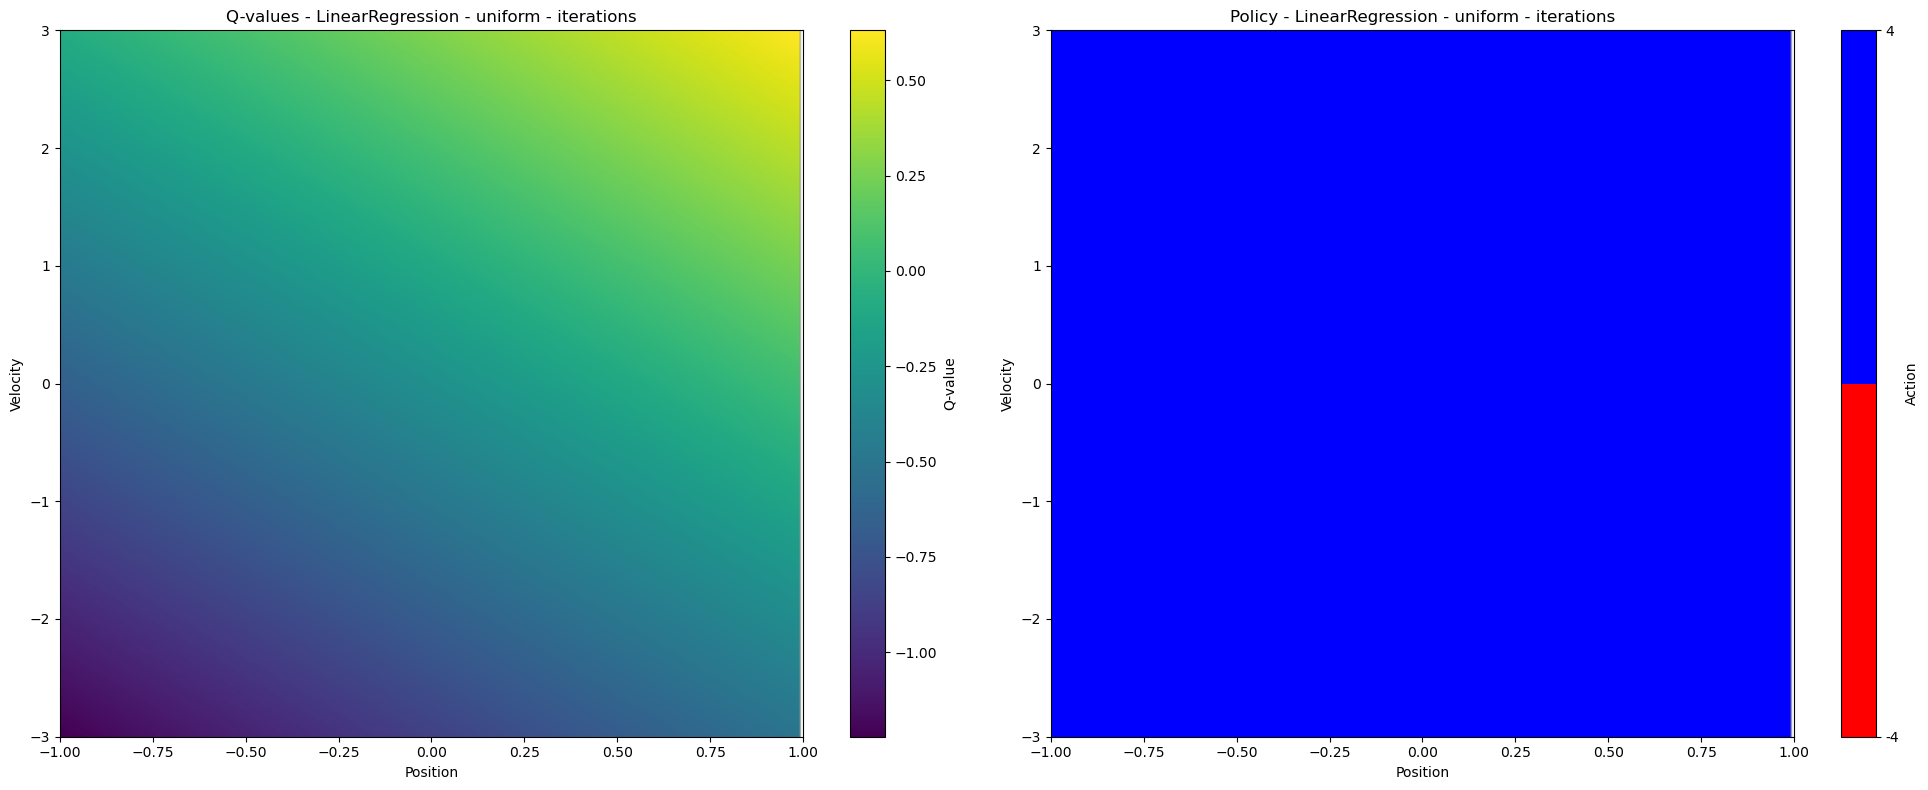

Training LinearRegression with uniform data using convergence stopping condition


 10%|█         | 10/100 [00:13<02:04,  1.39s/it]


Training completed after 10 iterations


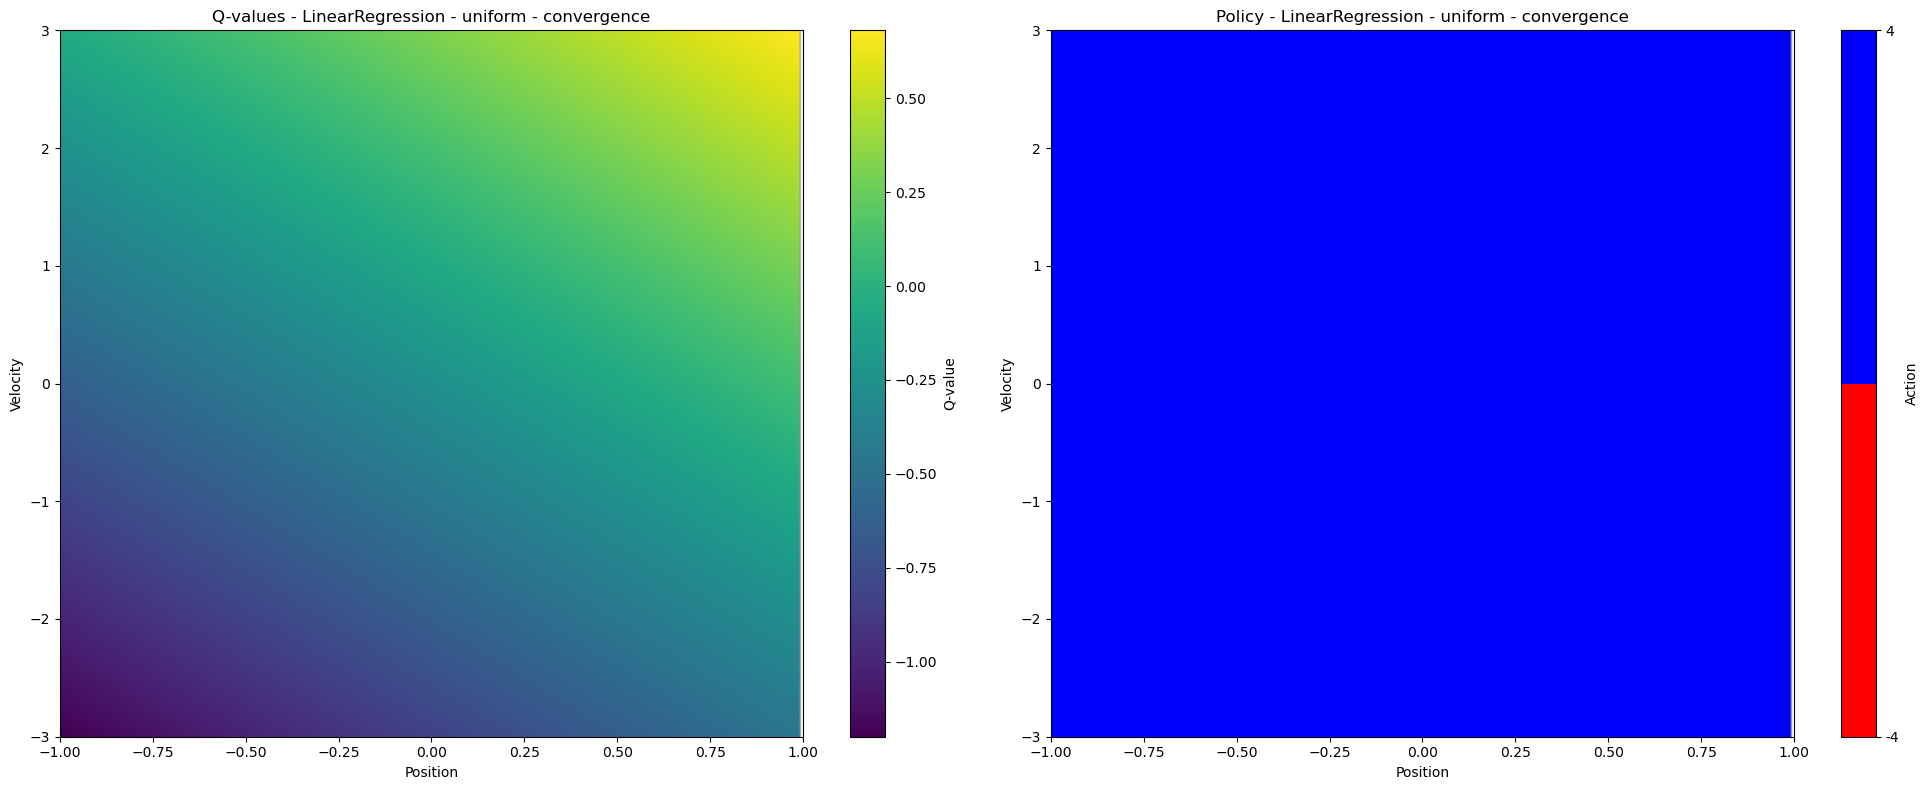

Training LinearRegression with episode data using iterations stopping condition


100%|██████████| 50/50 [00:11<00:00,  4.23it/s]


Training completed after 50 iterations


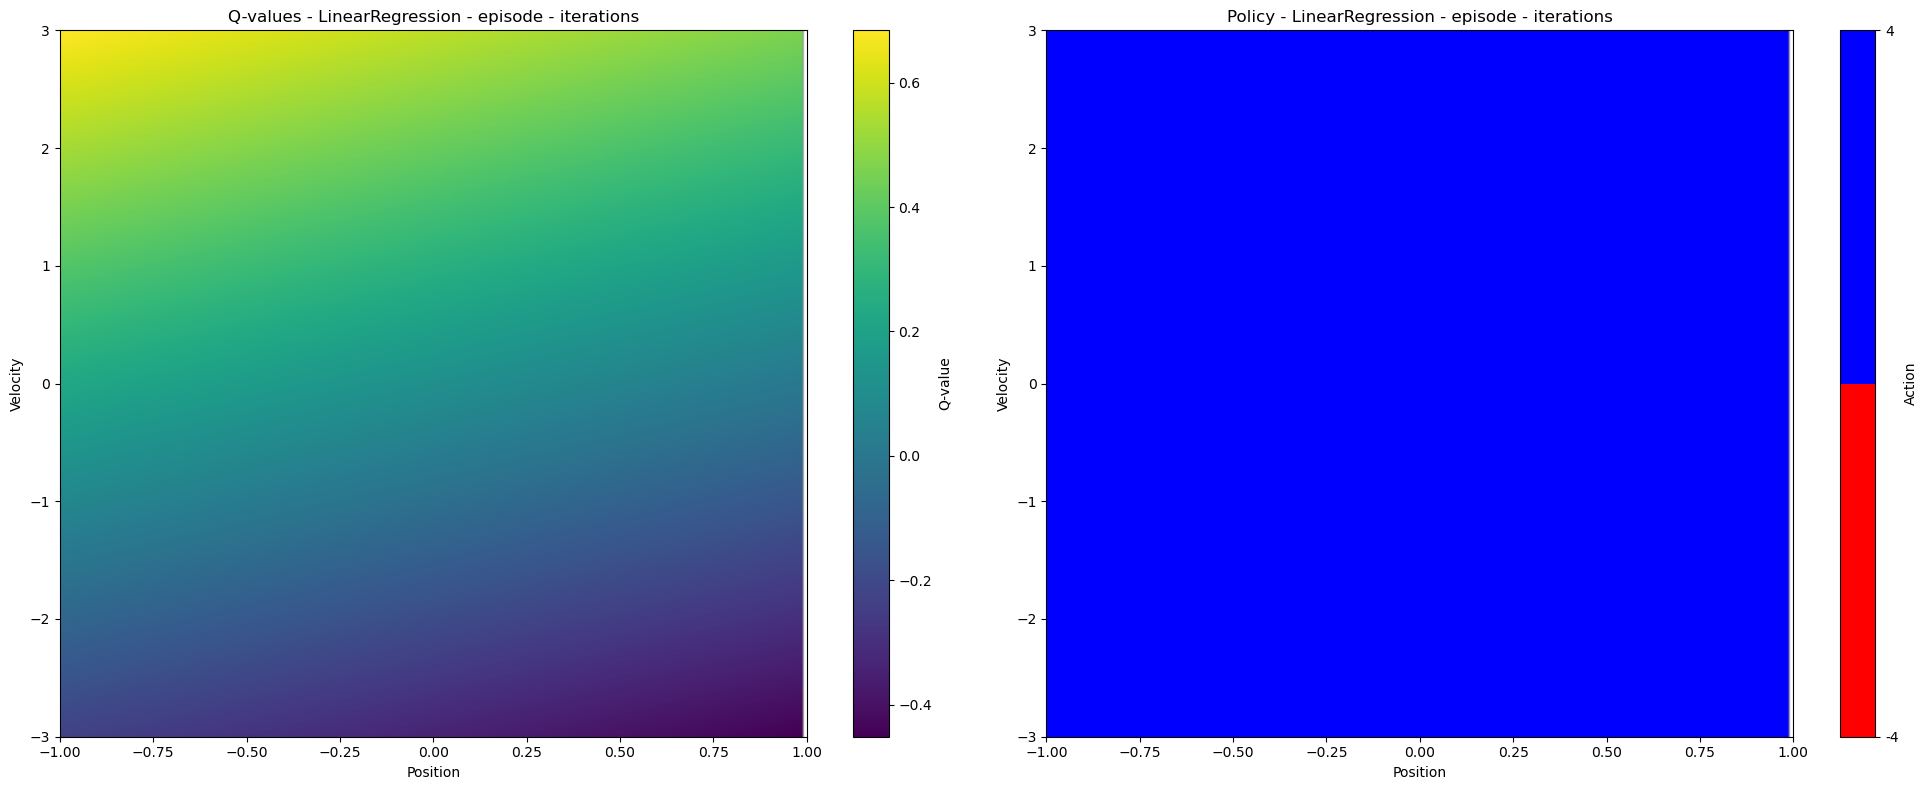

Training LinearRegression with episode data using convergence stopping condition


 14%|█▍        | 14/100 [00:04<00:28,  3.00it/s]


Training completed after 14 iterations


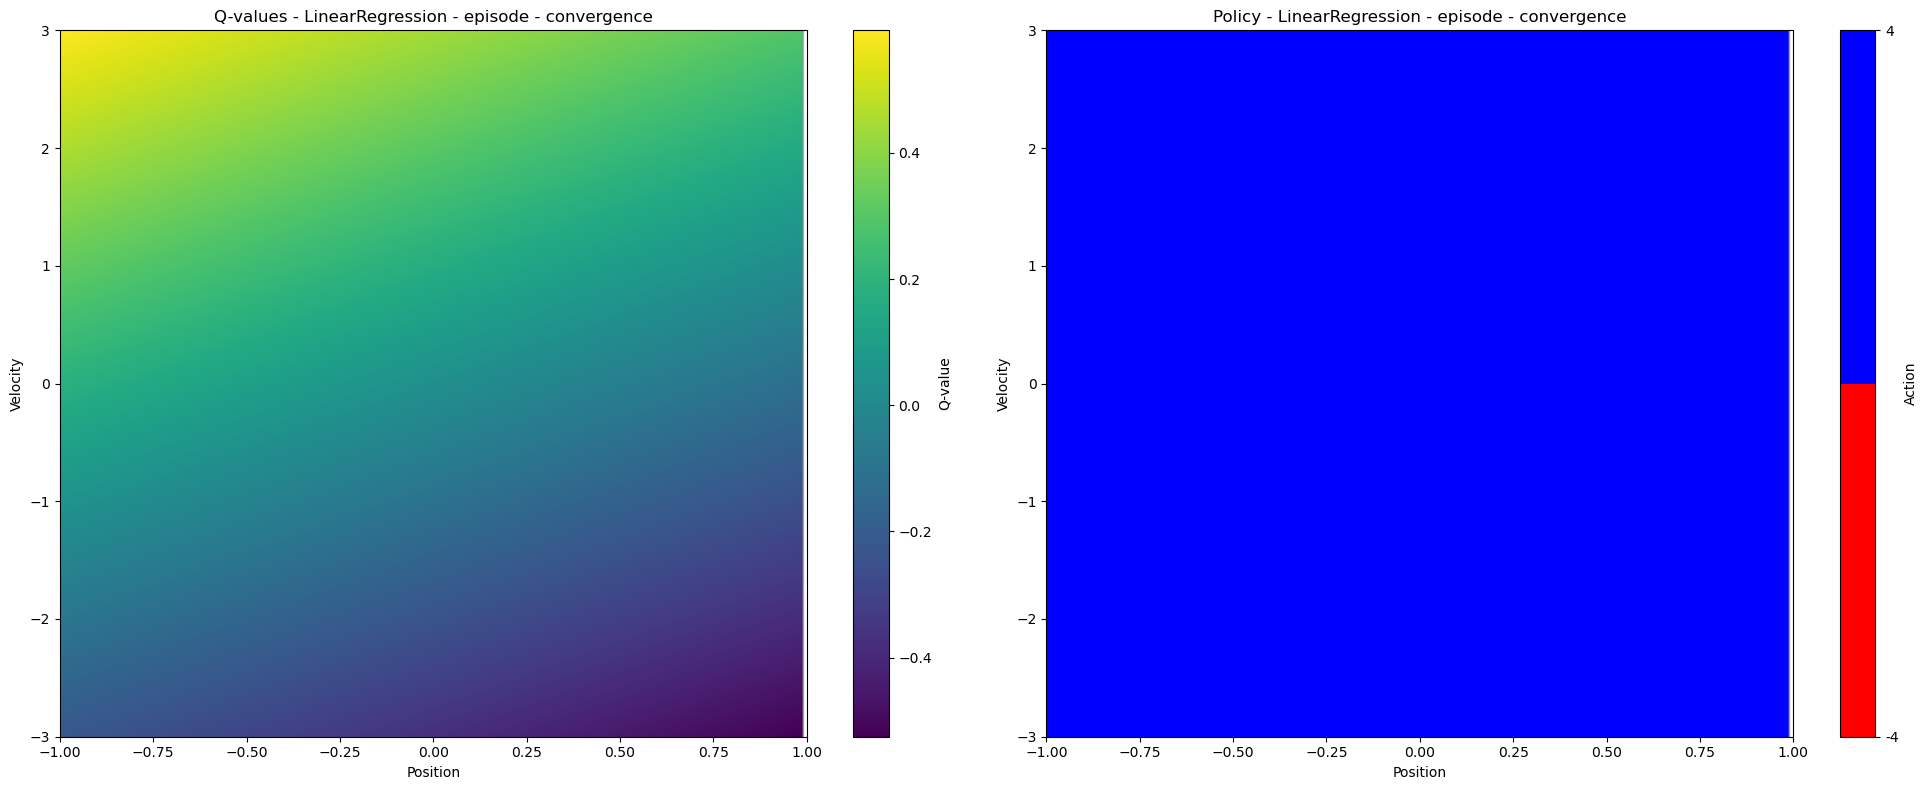

Training MLPRegressor with uniform data using iterations stopping condition


100%|██████████| 50/50 [05:07<00:00,  6.14s/it]


Training completed after 50 iterations


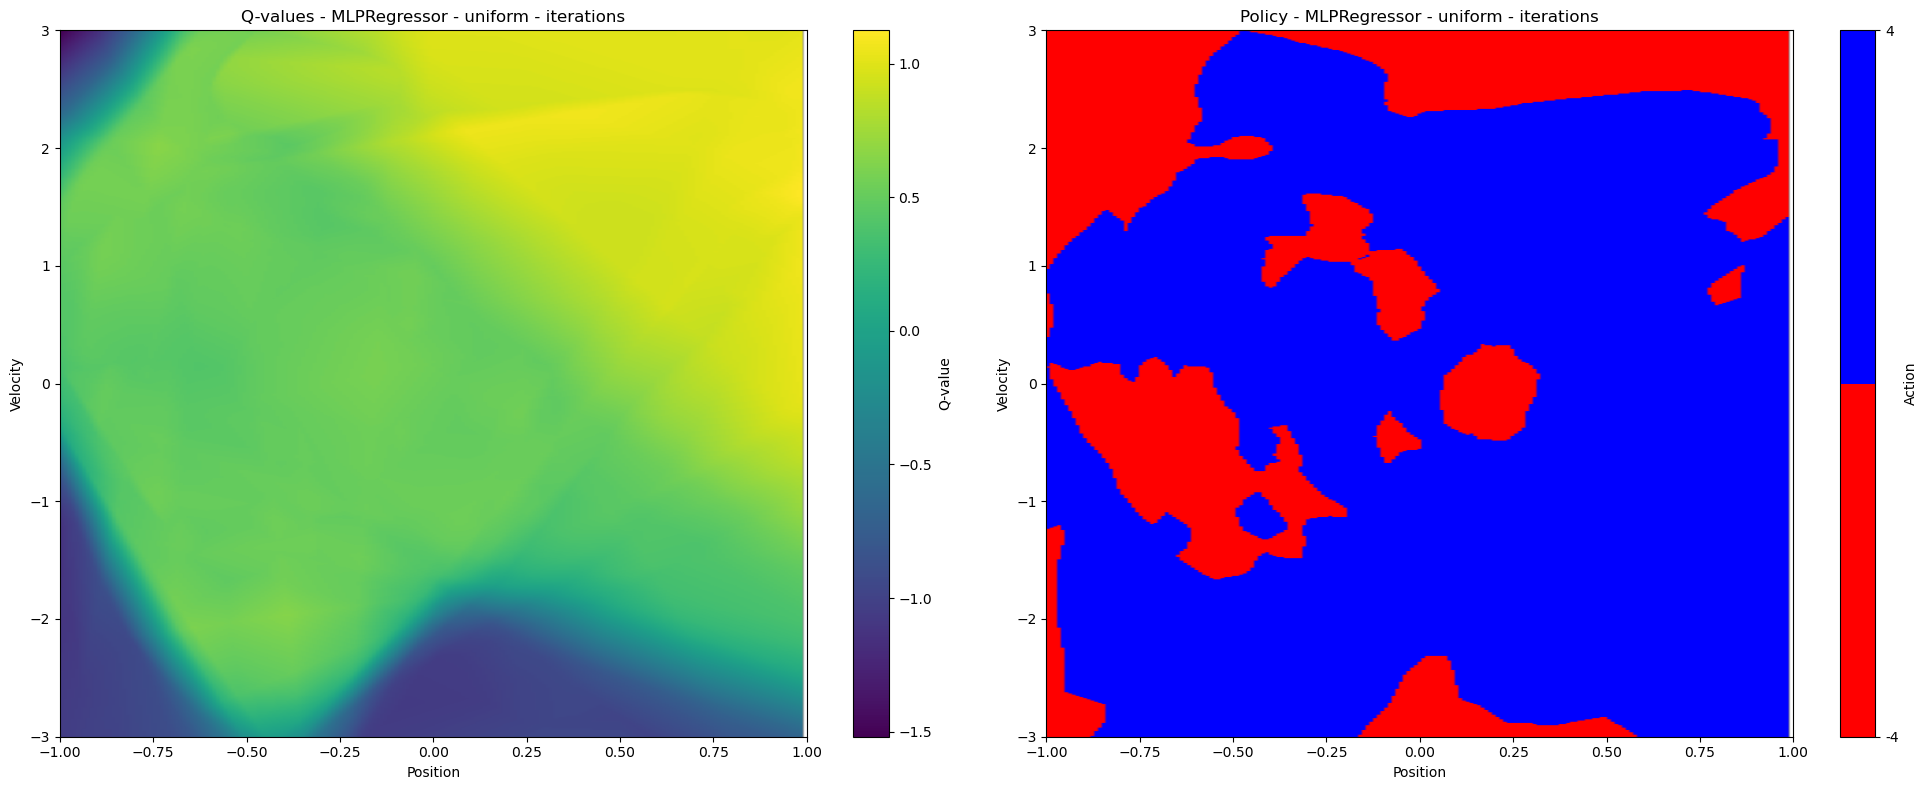

Training MLPRegressor with uniform data using convergence stopping condition


  7%|▋         | 7/100 [00:38<09:50,  6.35s/it]c:\Users\marti\anaconda3\envs\RL\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
 10%|█         | 10/100 [00:54<08:27,  5.64s/it]

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import ExtraTreesRegressor
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define models with appropriate hyperparameters
models = {
    "LinearRegression": LinearRegression(),
    "MLPRegressor": MLPRegressor(
        hidden_layer_sizes=(64, 64),  # Two hidden layers with 64 neurons each
        activation='relu',            # ReLU activation function
        solver='adam',                # Adam optimizer
        alpha=0.0001,                 # L2 regularization
        batch_size='auto',            # Automatic batch size
        learning_rate='adaptive',     # Adaptive learning rate
        max_iter=1000,                # Maximum iterations
        early_stopping=True,          # Early stopping
        validation_fraction=0.1,      # Validation set size
        n_iter_no_change=10,          # Iterations with no improvement for early stopping
        random_state=42               # Random seed for reproducibility
    ),
    "ExtraTreesRegressor": ExtraTreesRegressor(
        n_estimators=100,            # Number of trees
        max_depth=None,              # No maximum depth limit
        min_samples_split=2,         # Minimum samples to split a node
        min_samples_leaf=1,          # Minimum samples at leaf node
        max_features='auto',         # Auto feature selection
        bootstrap=False,             # Don't use bootstrap samples
        n_jobs=-1,                   # Use all available cores
        random_state=42              # Random seed for reproducibility
    )
}

# Define stopping conditions
stopping_conditions = ['iterations', 'convergence']

# Define tuple generation techniques
tuple_generation_techniques = [
    ('uniform', lambda env: generate_uniform_random_samples(env, n_samples=10000)),
    ('episode', lambda env: generate_episode_based_samples(env, n_episodes=100, max_steps=100))
]

def visualize_policy_and_qvalues(fqi, model_name, generation_technique, stopping_condition):
    """
    Visualize the Q-values and policy derived from the trained model.

    Parameters:
    - fqi: Trained FittedQIteration instance
    - model_name: Name of the model used
    - generation_technique: Name of the data generation technique
    - stopping_condition: Name of the stopping condition used
    """
    # Create grid of states
    p_range = np.arange(-1, 1.01, 0.01)
    v_range = np.arange(-3, 3.01, 0.01)

    # Initialize arrays to store Q-values and policy
    q_values = np.zeros((len(p_range), len(v_range)))
    policy = np.zeros((len(p_range), len(v_range)))

    # Calculate Q-values and policy for each state
    for i, p in enumerate(p_range):
        for j, v in enumerate(v_range):
            state = np.array([p, v])

            # Skip states outside valid region
            if abs(p) > 1 or abs(v) > 3:
                q_values[i, j] = np.nan
                policy[i, j] = np.nan
                continue

            # Get Q-values for each action
            q_vals = fqi.predict_Q(state)

            # Store max Q-value and best action
            q_values[i, j] = np.max(q_vals)
            policy[i, j] = np.argmax(q_vals)

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot Q-values
    im1 = ax1.imshow(q_values.T, origin='lower', aspect='auto',
                    extent=[-1, 1, -3, 3], cmap='viridis')
    ax1.set_title(f'Q-values - {model_name} - {generation_technique} - {stopping_condition}')
    ax1.set_xlabel('Position')
    ax1.set_ylabel('Velocity')
    plt.colorbar(im1, ax=ax1, label='Q-value')

    # Create custom colormap for policy (red for -4, blue for 4)
    cmap = LinearSegmentedColormap.from_list('custom', ['red', 'blue'], N=2)

    # Plot policy
    im2 = ax2.imshow(policy.T, origin='lower', aspect='auto',
                   extent=[-1, 1, -3, 3], cmap=cmap, vmin=0, vmax=1)
    ax2.set_title(f'Policy - {model_name} - {generation_technique} - {stopping_condition}')
    ax2.set_xlabel('Position')
    ax2.set_ylabel('Velocity')
    cbar = plt.colorbar(im2, ax=ax2, label='Action')
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(['-4', '4'])

    plt.tight_layout()
    plt.savefig(f'policy_{model_name}_{generation_technique}_{stopping_condition}.png')
    plt.show()

# Train FQI for each combination and store results
results = {}
trained_models = {}

# Create environment
env = CarOnHillEnv()

# Run experiments for each combination
for model_name, model in models.items():
    for gen_name, gen_func in tuple_generation_techniques:
        # Generate experience replay buffer
        experience_replay = gen_func(env)

        for stopping_condition in stopping_conditions:
            print(f"Training {model_name} with {gen_name} data using {stopping_condition} stopping condition")

            # Create FQI instance
            fqi = FittedQIteration(model=model, gamma=env.gamma, action_space=[-4, 4])

            # Train the model
            history = fqi.train(
                experience_replay=experience_replay,
                stopping_criteria=stopping_condition,
                max_iterations=400 if stopping_condition == 'iterations' else 100,
                convergence_threshold=0.01
            )

            # Store the trained model
            key = (model_name, gen_name, stopping_condition)
            trained_models[key] = fqi

            # Visualize policy and Q-values
            visualize_policy_and_qvalues(fqi, model_name, gen_name, stopping_condition)


In [1]:
# Choose a best model for evaluation - to be changed based on evaluation
# best_model_key = ('ExtraTreesRegressor', 'episode', 'convergence')
best_model_key = ('MLPRegressor', 'uniform', 'iterations')
eval_model = trained_models[best_model_key]

NameError: name 'trained_models' is not defined

In [ ]:
#play the policy

env = CarOnHillEnv(render_mode="gif")

num_steps = 100
state, _ = env.reset()
for _ in range(num_steps):
    action = eval_model.predict(state)
    next_state, reward, terminated, truncated, _ = env.step(action)
    if terminated or truncated:
        break
    state = next_state

env.save_gif("car_on_hill.gif")

### Question 4: Estimate and Display Expected Return

Estimate and display the expected return of $\widehat{\mu}_N^*$ in a table for each:
  - Supervised learning algorithm.
  - One-step system transitions generation strategy.
  - Stopping rule.

In [ ]:
def estimate_expected_return(env, fqi, n_episodes=100, max_steps=200):
    """
    Estimate the expected return of a policy derived from FQI.

    Parameters:
    - env: The environment
    - fqi: Trained FittedQIteration instance
    - n_episodes: Number of episodes to simulate
    - max_steps: Maximum steps per episode

    Returns:
    - Average return across all episodes
    """
    total_return = 0

    for _ in range(n_episodes):
        state, _ = env.reset()
        episode_return = 0
        step = 0
        gamma_power = 1  # γ^t

        for _ in range(max_steps):
            # Choose action according to the learned policy
            action_idx = np.argmax(fqi.predict_Q(state))
            action = 1 if fqi.action_space[action_idx] == 4 else 0  # Convert to env action

            # Take a step in the environment
            next_state, reward, terminated, truncated, _ = env.step(action)

            # Update return
            episode_return += gamma_power * reward
            gamma_power *= env.gamma

            # Update state
            state = next_state
            step += 1

            # Check termination
            if terminated or truncated:
                break

        total_return += episode_return

    return total_return / n_episodes

# Create a table of expected returns
results_table = np.zeros((len(models), len(tuple_generation_techniques), len(stopping_conditions)))

for i, model_name in enumerate(models.keys()):
    for j, (gen_name, _) in enumerate(tuple_generation_techniques):
        for k, stopping_condition in enumerate(stopping_conditions):
            key = (model_name, gen_name, stopping_condition)
            if key in trained_models:
                fqi = trained_models[key]
                expected_return = estimate_expected_return(env, fqi)
                results_table[i, j, k] = expected_return
                print(f"Expected return for {model_name}, {gen_name}, {stopping_condition}: {expected_return:.4f}")

# Display results in a formatted table
print("\nExpected Returns:")
print("-" * 80)
print(f"{'Model':<20} | {'Generation':<10} | {'Stopping':<10} | {'Return':<10}")
print("-" * 80)

for i, model_name in enumerate(models.keys()):
    for j, (gen_name, _) in enumerate(tuple_generation_techniques):
        for k, stopping_condition in enumerate(stopping_conditions):
            print(f"{model_name:<20} | {gen_name:<10} | {stopping_condition:<10} | {results_table[i, j, k]:<10.4f}")

# Play the policy of the best model
env = CarOnHillEnv(render_mode="gif")
best_model = trained_models[best_model_key]

num_steps = 100
state, _ = env.reset()
for _ in range(num_steps):
    q_values = best_model.predict_Q(state)
    action_idx = np.argmax(q_values)
    action = 1 if best_model.action_space[action_idx] == 4 else 0  # Convert to env action
    next_state, reward, terminated, truncated, _ = env.step(action)
    if terminated or truncated:
        break
    state = next_state

env.save_gif("car_on_hill.gif")

### Question 5: Results Discussion

Discuss the impact on the results for each:
- Supervised learning algorithm.
- One-step system transitions generation strategies.
- Stopping rules.


#### Answer: 

## Part 2: Parametric Q-Learning



### Question 1: Parametric Q-Learning Algorithm

Implement a routine which computes a parametrized approximation of the Q-function via the Parametric Q-Learning algorithm. Use a neural network as the approximation architecture, and motivate its structure. 


In [ ]:
import numpy as np
from sklearn.neural_network import MLPRegressor
from typing import List, Tuple

class ParametricQLearning:
    def __init__(self, model, gamma: float, action_space: List[int], learning_rate: float = 0.01):
        """
        Initialize the Parametric Q-Learning algorithm.

        Parameters:
        - model: A scikit-learn model used for approximating the Q-function.
        - gamma: Discount factor for future rewards.
        - action_space: List of possible actions.
        - learning_rate: Learning rate for updating the Q-function.
        """
        self.model = model
        self.gamma = gamma
        self.action_space = action_space
        self.learning_rate = learning_rate
        # Initialize Q-function as a lambda function
        self.q_function = lambda s, a: self.model.predict([np.append(s, a)])[0]

    def train(self, env, num_episodes: int, max_steps: int):
        """
        Train the Q-learning model over a number of episodes.

        Parameters:
        - env: The environment to train on.
        - num_episodes: Number of episodes to train for.
        - max_steps: Maximum number of steps per episode.
        """

    def select_action(self, state: np.ndarray) -> int:
        """
        Select an action using an epsilon-greedy policy.

        Parameters:
        - state: The current state of the environment.

        Returns:
        - An action from the action space.
        """
        pass

    def update_q_function(self, state: np.ndarray, action: int, reward: float, next_state: np.ndarray):
        """
        Update the Q-function using the Bellman equation.

        Parameters:
        - state: The current state.
        - action: The action taken.
        - reward: The reward received.
        - next_state: The next state after taking the action.
        """
        pass

    def predict_action(self, state: np.ndarray) -> int:
        """
        Predict the best action for a given state.

        Parameters:
        - state: The current state.

        Returns:
        - The action with the highest Q-value.
        """
        pass

In [ ]:
import numpy as np
from sklearn.neural_network import MLPRegressor
import torch
import torch.nn as nn
import torch.optim as optim
from typing import List, Tuple

class QNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        """
        Neural network for Q-function approximation.

        Parameters:
        - input_dim: Dimension of input (state + action)
        - hidden_dims: List of hidden layer dimensions
        - output_dim: Dimension of output (Q-value)
        """
        super(QNetwork, self).__init__()

        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, output_dim))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class ParametricQLearning:
    def __init__(self, state_dim=2, action_space=[0, 1], gamma=0.95,
                 learning_rate=0.001, epsilon=1.0, epsilon_decay=0.995,
                 epsilon_min=0.01, hidden_dims=[64, 64]):
        """
        Initialize the Parametric Q-Learning algorithm.

        Parameters:
        - state_dim: Dimension of the state space
        - action_space: List of possible actions (indices)
        - gamma: Discount factor for future rewards
        - learning_rate: Learning rate for updating the Q-function
        - epsilon: Initial exploration rate
        - epsilon_decay: Decay rate for epsilon
        - epsilon_min: Minimum epsilon value
        - hidden_dims: Dimensions of hidden layers in the neural network
        """
        self.gamma = gamma
        self.action_space = action_space
        self.action_values = [-4, 4]  # Actual action values
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        # Input dimension is state dimension + 1 for action
        self.q_network = QNetwork(state_dim + 1, hidden_dims, 1)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()

        # Experience buffer
        self.buffer = []
        self.max_buffer_size = 10000

    def q_function(self, state, action_idx):
        """
        Compute Q(s,a) using the neural network.

        Parameters:
        - state: The current state
        - action_idx: Index of the action (0 or 1)

        Returns:
        - Q-value for the given state-action pair
        """
        # Convert action index to actual value and append to state
        action_value = self.action_values[action_idx]
        state_action = np.append(state, action_value)

        # Convert to tensor
        state_action_tensor = torch.FloatTensor(state_action)

        # Get Q-value
        with torch.no_grad():
            q_value = self.q_network(state_action_tensor)

        return q_value.item()

    def select_action(self, state, epsilon=None):
        """
        Select an action using an epsilon-greedy policy.

        Parameters:
        - state: The current state of the environment
        - epsilon: Override the current epsilon value (optional)

        Returns:
        - An action index from the action space
        """
        if epsilon is None:
            epsilon = self.epsilon

        # Explore: choose a random action
        if np.random.random() < epsilon:
            return np.random.choice(self.action_space)

        # Exploit: choose the best action
        q_values = [self.q_function(state, a) for a in self.action_space]
        return self.action_space[np.argmax(q_values)]

    def add_to_buffer(self, experience):
        """
        Add an experience tuple to the replay buffer.

        Parameters:
        - experience: Tuple of (state, action, reward, next_state, done)
        """
        self.buffer.append(experience)
        if len(self.buffer) > self.max_buffer_size:
            self.buffer.pop(0)

    def sample_from_buffer(self, batch_size):
        """
        Sample a batch of experiences from the buffer.

        Parameters:
        - batch_size: Number of experiences to sample

        Returns:
        - Batch of experiences
        """
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        return [self.buffer[i] for i in indices]

    def update_q_function(self, state, action_idx, reward, next_state, done, batch_size=32):
        """
        Update the Q-function using the Bellman equation and experience replay.

        Parameters:
        - state: The current state
        - action_idx: Index of the action taken
        - reward: The reward received
        - next_state: The next state after taking the action
        - done: Whether the episode is done
        - batch_size: Size of the batch for training
        """
        # Add experience to buffer
        self.add_to_buffer((state, action_idx, reward, next_state, done))

        # If buffer is too small, don't train yet
        if len(self.buffer) < batch_size:
            return

        # Sample batch from buffer
        batch = self.sample_from_buffer(batch_size)

        states = []
        actions = []
        targets = []

        for s, a, r, s_next, d in batch:
            # Get the action value from the index
            action_value = self.action_values[a]

            # Compute target Q-value
            target = r
            if not d:
                # Get max Q-value for next state
                next_q_values = [self.q_function(s_next, a_next) for a_next in self.action_space]
                target += self.gamma * max(next_q_values)

            # Append to training data
            states.append(s)
            actions.append(action_value)
            targets.append(target)

        # Convert to tensors
        state_action_tensors = torch.FloatTensor(np.column_stack((states, actions)))
        target_tensors = torch.FloatTensor(targets).unsqueeze(1)

        # Train network
        self.optimizer.zero_grad()
        predicted_q_values = self.q_network(state_action_tensors)
        loss = self.criterion(predicted_q_values, target_tensors)
        loss.backward()
        self.optimizer.step()

        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        return loss.item()

    def train(self, env, num_episodes=1000, max_steps=1000):
        """
        Train the Q-learning model over a number of episodes.

        Parameters:
        - env: The environment to train on
        - num_episodes: Number of episodes to train for
        - max_steps: Maximum number of steps per episode

        Returns:
        - List of total rewards per episode
        """
        rewards_history = []

        for episode in range(num_episodes):
            state, _ = env.reset()
            total_reward = 0

            for step in range(max_steps):
                # Select action
                action_idx = self.select_action(state)

                # Take action
                next_state, reward, terminated, truncated, _ = env.step(action_idx)
                done = terminated or truncated

                # Update Q-function
                self.update_q_function(state, action_idx, reward, next_state, done)

                total_reward += reward
                state = next_state

                if done:
                    break

            rewards_history.append(total_reward)

            # Print progress
            if (episode + 1) % 10 == 0:
                avg_reward = np.mean(rewards_history[-10:])
                print(f"Episode {episode+1}/{num_episodes}, Avg Reward: {avg_reward:.2f}, Epsilon: {self.epsilon:.2f}")

        return rewards_history

    def predict_action(self, state):
        """
        Predict the best action for a given state.

        Parameters:
        - state: The current state

        Returns:
        - The action with the highest Q-value
        """
        q_values = [self.q_function(state, a) for a in self.action_space]
        return self.action_space[np.argmax(q_values)]

### Question 2: Policy Derivation and Visualization

Derive the policy $\widehat{\mu}_*$ from $\widehat{Q}$ and display it in a colored 2D grid. Use red for action a = -4 and blue for action a = 4, with a resolution of 0.01 for the state space display.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def visualize_policy(q_learning, resolution=0.01):
    """
    Visualize the policy derived from the Q-function.

    Parameters:
    - q_learning: Trained ParametricQLearning instance
    - resolution: Resolution for the state space grid
    """
    # Create a grid of states
    position = np.arange(-1.0, 1.0 + resolution, resolution)
    velocity = np.arange(-3.0, 3.0 + resolution, resolution)

    # Initialize policy grid
    policy_grid = np.zeros((len(velocity), len(position)))

    # For each state in the grid, find the best action
    for i, v in enumerate(velocity):
        for j, p in enumerate(position):
            state = np.array([p, v])
            action_idx = q_learning.predict_action(state)
            # Set policy grid value (0 for action -4, 1 for action 4)
            policy_grid[i, j] = action_idx

    # Create a colormap (red for -4, blue for 4)
    cmap = ListedColormap(['red', 'blue'])

    # Plot the policy
    plt.figure(figsize=(10, 8))
    plt.imshow(policy_grid, cmap=cmap, extent=[-1, 1, -3, 3], origin='lower', aspect='auto')
    plt.colorbar(ticks=[0, 1], label='Action')
    plt.clim(-0.5, 1.5)
    plt.xlabel('Position')
    plt.ylabel('Velocity')
    plt.title('Policy: Red = -4, Blue = 4')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig('policy_visualization.png')
    plt.show()

# Train the model
def train_and_visualize():
    # Create environment
    env = CarOnHillEnv()

    # Create and train Q-learning agent
    q_learning = ParametricQLearning(
        state_dim=2,
        action_space=[0, 1],  # 0: -4, 1: 4
        gamma=0.95,
        learning_rate=0.001,
        epsilon=1.0,
        epsilon_decay=0.995,
        hidden_dims=[64, 64]
    )

    # Train the agent
    rewards = q_learning.train(env, num_episodes=500, max_steps=200)

    # Plot learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Learning Curve')
    plt.grid(True)
    plt.savefig('learning_curve.png')
    plt.show()

    # Visualize the policy
    visualize_policy(q_learning, resolution=0.02)  # Using 0.02 for faster visualization

    return q_learning, rewards

# Run training and visualization
q_learning, rewards = train_and_visualize()

### Question 3: Expected Return Estimation

Estimate and show the expected return of $\widehat{\mu}^*$.


In [ ]:
def estimate_expected_return(q_learning, env, num_episodes=100):
    """
    Estimate the expected return of the policy derived from the Q-function.

    Parameters:
    - q_learning: Trained ParametricQLearning instance
    - env: Environment to evaluate on
    - num_episodes: Number of episodes to run for estimation

    Returns:
    - Average return over all episodes
    """
    total_returns = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_return = 0
        done = False
        step = 0

        while not done and step < 1000:  # Limiting to 1000 steps to avoid infinite loops
            # Select action according to the policy (no exploration)
            action_idx = q_learning.predict_action(state)

            # Take action
            next_state, reward, terminated, truncated, _ = env.step(action_idx)
            done = terminated or truncated

            # Update return
            episode_return += (q_learning.gamma ** step) * reward

            # Update state
            state = next_state
            step += 1

        total_returns.append(episode_return)

    # Calculate average return
    avg_return = np.mean(total_returns)
    std_return = np.std(total_returns)

    print(f"Expected return: {avg_return:.4f} ± {std_return:.4f}")

    # Plot histogram of returns
    plt.figure(figsize=(10, 6))
    plt.hist(total_returns, bins=20, alpha=0.7)
    plt.axvline(avg_return, color='red', linestyle='dashed', linewidth=2)
    plt.xlabel('Return')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Returns (Mean: {avg_return:.4f})')
    plt.grid(True)
    plt.savefig('return_distribution.png')
    plt.show()

    return avg_return, std_return

# Create a new environment for evaluation
eval_env = CarOnHillEnv()

# Estimate expected return
avg_return, std_return = estimate_expected_return(q_learning, eval_env, num_episodes=100)

### Question 4: Experimental Protocol Design

Design an experimental protocol to compare Fitted Q Iteration (FQI) and Parametric Q-Learning. Use a curve plot where the x-axis represents the number of one-step system transitions and the y-axis represents the expected return.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def run_comparison_experiment(max_transitions=50000, eval_interval=5000):
    """
    Run an experiment to compare FQI and Parametric Q-Learning.

    Parameters:
    - max_transitions: Maximum number of transitions to collect
    - eval_interval: Number of transitions between evaluations

    Returns:
    - Results of the experiment
    """
    # Create environment
    env = CarOnHillEnv()
    eval_env = CarOnHillEnv()

    # Initialize algorithms
    fqi = FittedQIteration(gamma=0.95)
    pql = ParametricQLearning(gamma=0.95, epsilon=1.0, epsilon_decay=0.9999)

    # Initialize buffers
    buffer = []

    # Initialize results
    transitions = []
    fqi_returns = []
    pql_returns = []

    # Collect transitions
    state, _ = env.reset()
    num_transitions = 0

    with tqdm(total=max_transitions) as pbar:
        while num_transitions < max_transitions:
            # Choose random action (exploration)
            action = np.random.choice([0, 1])

            # Take action
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Store transition
            buffer.append((state, action, reward, next_state, done))

            # Update state
            if done:
                state, _ = env.reset()
            else:
                state = next_state

            num_transitions += 1
            pbar.update(1)

            # Evaluate at intervals
            if num_transitions % eval_interval == 0 or num_transitions == max_transitions:
                # Train FQI on the entire buffer
                fqi.fit(buffer)

                # Train PQL on the entire buffer (in batches)
                np.random.shuffle(buffer)
                batch_size = 32
                for i in range(0, len(buffer), batch_size):
                    batch = buffer[i:i+batch_size]
                    for state, action, reward, next_state, done in batch:
                        pql.update_q_function(state, action, reward, next_state, done, batch_size=min(batch_size, len(batch)))

                # Evaluate FQI
                fqi_return = evaluate_policy(fqi, eval_env, num_episodes=10)

                # Evaluate PQL
                pql_return = evaluate_policy(pql, eval_env, num_episodes=10)

                # Store results
                transitions.append(num_transitions)
                fqi_returns.append(fqi_return)
                pql_returns.append(pql_return)

                print(f"Transitions: {num_transitions}, FQI Return: {fqi_return:.4f}, PQL Return: {pql_return:.4f}")

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(transitions, fqi_returns, label='Fitted Q Iteration', marker='o')
    plt.plot(transitions, pql_returns, label='Parametric Q-Learning', marker='s')
    plt.xlabel('Number of Transitions')
    plt.ylabel('Expected Return')
    plt.title('FQI vs Parametric Q-Learning')
    plt.legend()
    plt.grid(True)
    plt.savefig('comparison_results.png')
    plt.show()

    return {
        'transitions': transitions,
        'fqi_returns': fqi_returns,
        'pql_returns': pql_returns
    }

def evaluate_policy(agent, env, num_episodes=10):
    """
    Evaluate a policy over multiple episodes.

    Parameters:
    - agent: Either FQI or PQL agent
    - env: Environment to evaluate on
    - num_episodes: Number of episodes for evaluation

    Returns:
    - Average return
    """
    total_returns = []

    for _ in range(num_episodes):
        state, _ = env.reset()
        episode_return = 0
        done = False
        step = 0

        while not done and step < 200:  # Limit steps to avoid infinite loops
            # Select action according to the policy
            action = agent.predict_action(state)

            # Take action
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Update return
            episode_return += (0.95 ** step) * reward

            # Update state
            state = next_state
            step += 1

        total_returns.append(episode_return)

    return np.mean(total_returns)

# Run the experiment
comparison_results = run_comparison_experiment(max_transitions=20000, eval_interval=2000)

### Question 5: Results Discussion

Discuss the results obtained by running the experimental protocol. Consider the differences in performance between FQI and Parametric Q-Learning, and any insights gained from the comparison.

#### Answer: 